# Differential Photometry

Now we load one science frame to highlight the selected stars, in the previous file we removed the frames affected by an anomalous sky background value due to clouds and light pollution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
import pickle
import matplotlib.colors as colors

science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
science_frame_name = './group10_WASP-135_20190803/correct/' + science_list[0][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

The following functions have been taken from the previous notebook.

In [2]:
def make_annulus_around_star(x_pos, y_pos,  inner_radius, outer_radius, label='', color='y'):
    from matplotlib.patches import Circle

    n, radii = 50, [inner_radius, outer_radius]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)



def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)

Now we implement the coordinates of the target and reference stars, as well as the aperture photometry parameters that we derived in the previous lectures. Next we plot the frame with the annulus to highlight the target and the reference stars.

vmin:  1067.9    vmax: 110239.3


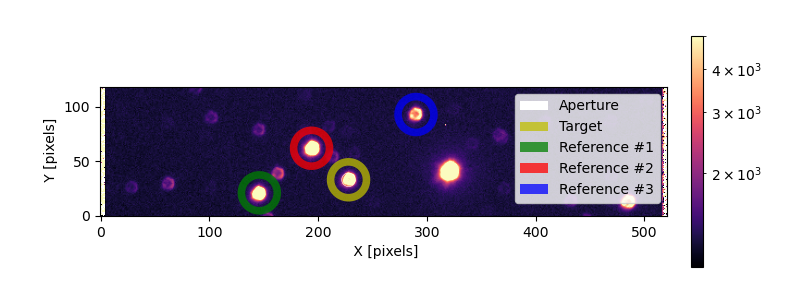

In [3]:
x_target = 228
y_target = 33

x_reference_01 = 146
y_reference_01 = 21

x_reference_02 = 194
y_reference_02 = 62

x_reference_03 = 290
y_reference_03 = 93

aperture = 6
inner_radius = 13
outer_radius = 20

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, aperture, label='Aperture')

make_annulus_around_star(x_target, y_target, inner_radius, outer_radius, label='Target')
make_annulus_around_star(x_reference_01, y_reference_01, inner_radius, outer_radius, label='Reference #1', color='g')
make_annulus_around_star(x_reference_02, y_reference_02, inner_radius, outer_radius, label='Reference #2', color='r')
make_annulus_around_star(x_reference_03, y_reference_03, inner_radius, outer_radius, label='Reference #3', color='b')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

### Importing the *AperturePhotometry* class
Now we use the ```AperturePhotometry``` class to perform aperture photometry on the target and the three reference stars.

In [4]:
from aperture_photometry import AperturePhotometry

target_ap06 = AperturePhotometry()
target_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_target, y_target)

reference01_ap06 = AperturePhotometry()
reference01_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_01, y_reference_01)

reference02_ap06 = AperturePhotometry()
reference02_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_02, y_reference_02)

reference03_ap06 = AperturePhotometry()
reference03_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_03, y_reference_03)

c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error = science_corre

### Tracking weather and instrument conditions.

### Tracking weather and instrument conditions during the night

We will now realize a plot with some observables of interest as a function of time:

1. Flux of all stars normalized to the value of the 200th observation (it could be any observation actually) to better compare the flux of stars with different magnitudes.

2. The **AIRMASS** as a function of time.

3. Sky Flux. Higher values may be associated with increasing airmass (light pollution) but also variable weather. Useful if we want to exclude some observations or a reference star if the background has a weird behaviour (due to the presence of a contaminant star near the sky annulus).

4. Variation of the position of the target on the CCD during the night in both directions. You may want to exclude observations affected by sudden jumps.

5. The last panel shows the FWHM of the target, in both directions (NOT IMPLEMENTED IN THE CLASS YET).

We already performed this step in the previous lecture and we encountered an anomaly in the sky background due to clouds. Now that we have overwritten the science.list file removing the interested frames, we expect a more normal behaviour.


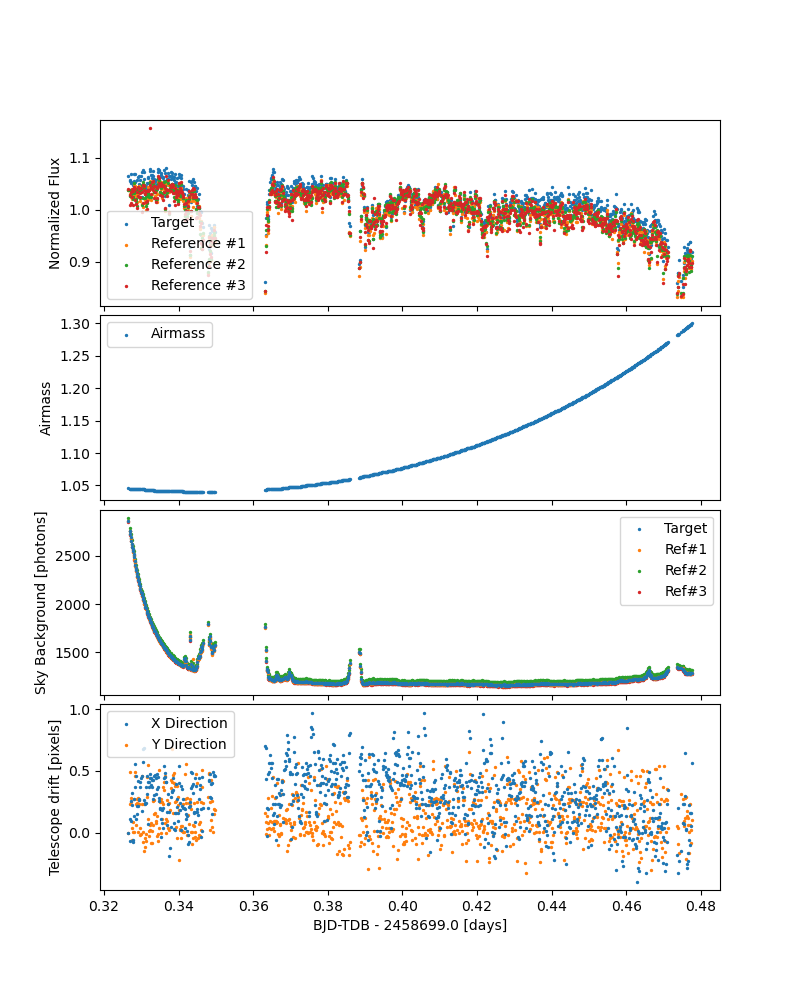

In [5]:
normalization_index = 500 # We divide the flux by the flux of the 200th frame
time_offset = 2458699.0 # This parameter is used only to have values of time close to zero in the plot.

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,10))
# Reduce vertical space between axes
fig.subplots_adjust(hspace=0.05)

# Normalized Flux Plot
axs[0].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/target_ap06.aperture[normalization_index], s=2, zorder=3, c='C0', label='Target')
axs[0].scatter(reference01_ap06.bjd_tdb-time_offset, reference01_ap06.aperture/reference01_ap06.aperture[normalization_index], s=2, zorder=3, c='C1', label='Reference #1')
axs[0].scatter(reference02_ap06.bjd_tdb-time_offset, reference02_ap06.aperture/reference02_ap06.aperture[normalization_index], s=2, zorder=3, c='C2', label='Reference #2')
axs[0].scatter(reference03_ap06.bjd_tdb-time_offset, reference03_ap06.aperture/reference03_ap06.aperture[normalization_index], s=2, zorder=3, c='C3', label='Reference #3')
axs[0].set_ylabel('Normalized Flux')


axs[0].legend()

# Airmass Plot
axs[1].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.airmass, s=2, c='C0', label='Airmass')
axs[1].set_ylabel('Airmass')
axs[1].legend()

# Sky Flux Plot
axs[2].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.sky_background, s=2, c='C0', zorder=4, label='Target')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference01_ap06.sky_background, s=2, c='C1', zorder=3, label='Ref#1')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference02_ap06.sky_background, s=2, c='C2', zorder=2, label='Ref#2')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference03_ap06.sky_background, s=2, c='C3', zorder=1, label='Ref#3')

axs[2].set_ylabel('Sky Background [photons]')
axs[2].legend()

# Telescope Drift
axs[3].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.x_position-target_ap06.x_position[0], s=2, c='C0', zorder=2, label='X Direction')
axs[3].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.y_position-target_ap06.y_position[0], s=2, c='C1', zorder=1, label='Y Direction')
axs[3].set_ylabel('Telescope drift [pixels]')
axs[3].legend()
axs[3].set_xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.show()

As we can see there are some blank vertical bands in correspondence with the missing frames.

### Computing the Differential Photometry

We can see from the first panel that the absolute flux is variable during the night due to many factors. Comparing the flux of the target star with the flux of the reference stars highlights how these effects simultaneously affect all the stars. The planet's transit in the target star is barely visible as a depression in the flux compared to the reference stars. We will deal with all these effects by performing **differential photometry**.

Comparison stars will be affected similarly by the factors discussed, so, by measuring comparison stars, any variation can be used to correct the measurementes of the target object. They are used to cancel out the instrumental effects in the measurements of the target star.

If we assume that these effects (seeing variation, weather conditions, increase in background luminosity) affect the observed fluxes proportionally, e.g., an increase in cloud coverage causes a decrease in the flux of a factor that is the same for all the stars. We can remove these effects by dividing the flux of the target star by the flux of the reference star. To increase the precision of our correction, we can also divide the flux of the target star by the sum of the fluxes of the reference stars, including only those reference stars that do not show anomalous behaviour (e.g., strange variation in the absolute flux or sky background not observed in other stars)



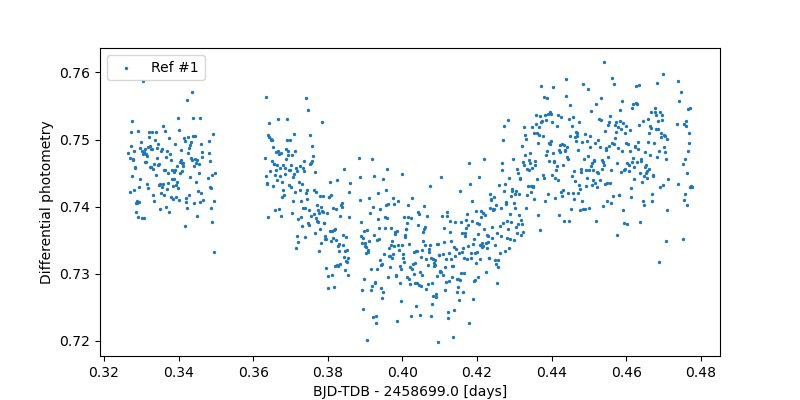

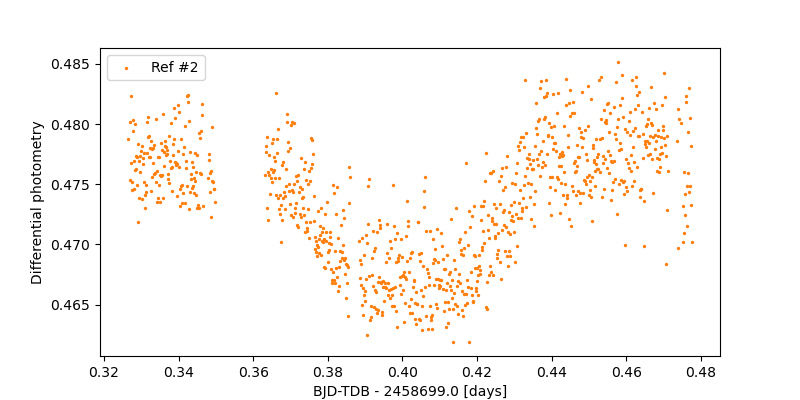

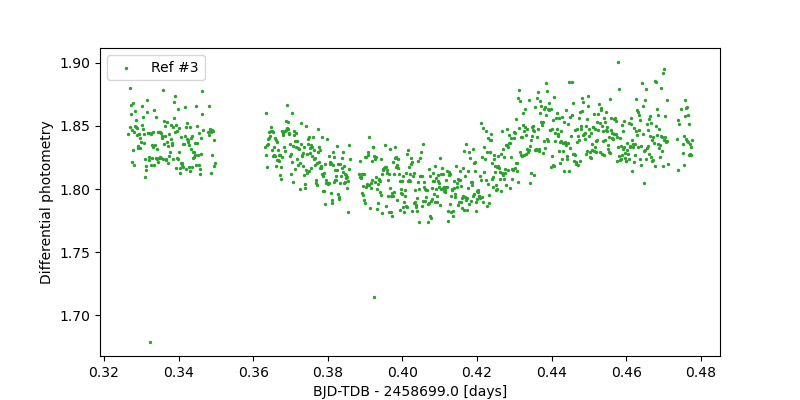

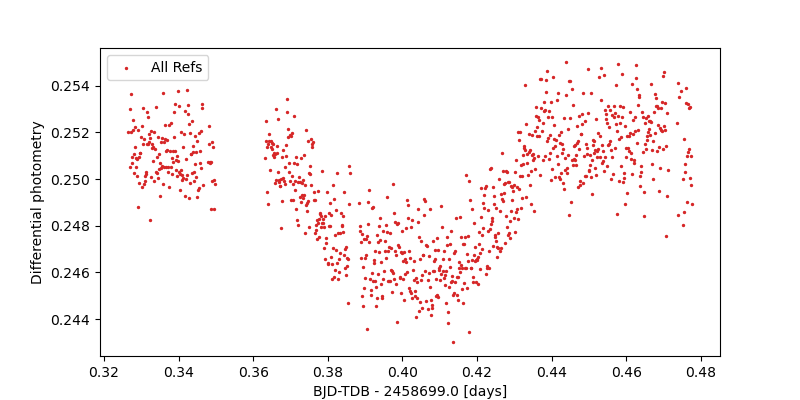

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/reference01_ap06.aperture, s=2, c='C0', label='Ref #1')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
#plt.ylim(2.200, 2.300)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/reference02_ap06.aperture, s=2, c='C1', label='Ref #2')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
#plt.ylim(2.200, 2.300)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/reference03_ap06.aperture, s=2, c='C2', label='Ref #3')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
#plt.ylim(2.200, 2.300)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/(reference01_ap06.aperture + reference02_ap06.aperture + reference03_ap06.aperture), s=2, c='C3', label='All Refs')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
#plt.ylim(2.200, 2.300)
plt.legend()
plt.show()

### Selection of the best differential photometry
The plots above show the differential photometry with a single reference star or with all the stars together. We need to find a quantitative criterion to select the best differential photometry. Generally speaking the answer relies on the physical phenomenon we want to study (in this case, a transit). We know that in the short time around the observations, the flux of the star can be considered constant, so the measurements obtained before and after the transit provide the opportunity to identify the differential approach delivering the best results.

Since we expect a constant value, the **standard deviation** of this portion of the light curve can provide a quantitative criterion for selecting the best photometric extraction.

First, we manually select the interval of exclusion fro the transit. What is really important is to always ues the same selection to compute the std dev across different combination of reference stars and aperture selections.

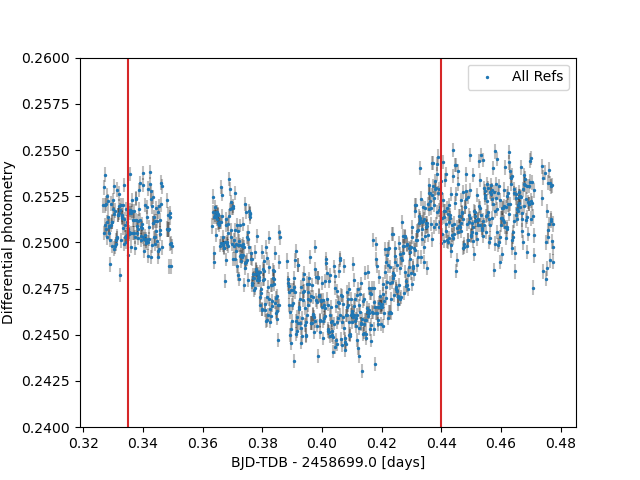

In [7]:
differential_ap06_ref01 = target_ap06.aperture/reference01_ap06.aperture
differential_ap06_ref02 = target_ap06.aperture/reference02_ap06.aperture
differential_ap06_ref03 = target_ap06.aperture/reference03_ap06.aperture

differential_ap06_ref01_ref02 = target_ap06.aperture / (reference01_ap06.aperture+reference02_ap06.aperture)
differential_ap06_ref01_ref03 = target_ap06.aperture / (reference01_ap06.aperture+reference03_ap06.aperture)
differential_ap06_ref02_ref03 = target_ap06.aperture / (reference02_ap06.aperture+reference03_ap06.aperture)

differential_ap06_allref = target_ap06.aperture / (reference01_ap06.aperture+reference02_ap06.aperture+reference03_ap06.aperture)

differential_ap06_ref01_error = np.sqrt((target_ap06.aperture_error/reference01_ap06.aperture)**2 + (target_ap06.aperture*reference01_ap06.aperture_error/reference01_ap06.aperture**2)**2)
differential_ap06_ref02_error = np.sqrt((target_ap06.aperture_error/reference02_ap06.aperture)**2 + (target_ap06.aperture*reference02_ap06.aperture_error/reference02_ap06.aperture**2)**2)
differential_ap06_ref03_error = np.sqrt((target_ap06.aperture_error/reference03_ap06.aperture)**2 + (target_ap06.aperture*reference03_ap06.aperture_error/reference03_ap06.aperture**2)**2)

differential_ap06_ref01_ref02_error = np.sqrt((target_ap06.aperture_error/(reference01_ap06.aperture+reference02_ap06.aperture))**2 + (target_ap06.aperture*reference01_ap06.aperture_error/(reference01_ap06.aperture + reference02_ap06.aperture)**2)**2 + (target_ap06.aperture*reference02_ap06.aperture_error/(reference01_ap06.aperture+reference02_ap06.aperture)**2)**2)
differential_ap06_ref01_ref03_error = np.sqrt((target_ap06.aperture_error/(reference01_ap06.aperture+reference03_ap06.aperture))**2 + (target_ap06.aperture*reference01_ap06.aperture_error/(reference01_ap06.aperture + reference03_ap06.aperture)**2)**2 + (target_ap06.aperture*reference03_ap06.aperture_error/(reference01_ap06.aperture+reference03_ap06.aperture)**2)**2)
differential_ap06_ref02_ref03_error = np.sqrt((target_ap06.aperture_error/(reference02_ap06.aperture+reference03_ap06.aperture))**2 + (target_ap06.aperture*reference02_ap06.aperture_error/(reference02_ap06.aperture + reference03_ap06.aperture)**2)**2 + (target_ap06.aperture*reference03_ap06.aperture_error/(reference02_ap06.aperture+reference03_ap06.aperture)**2)**2)

import numpy as np

# Variabili
a = target_ap06.aperture
b = reference01_ap06.aperture
c = reference02_ap06.aperture
d = reference03_ap06.aperture

sigma_a = target_ap06.aperture_error
sigma_b = reference01_ap06.aperture_error
sigma_c = reference02_ap06.aperture_error
sigma_d = reference03_ap06.aperture_error

# Denominatore
denom = b + c + d

# Calcolo dell'errore usando la propagazione degli errori
differential_ap06_allref_error = np.sqrt(
    (sigma_a / denom) ** 2 +
    (a * sigma_b / denom ** 2) ** 2 +
    (a * sigma_c / denom ** 2) ** 2 +
    (a * sigma_d / denom ** 2) ** 2
)

plt.figure()
plt.scatter(target_ap06.bjd_tdb-time_offset, differential_ap06_allref, s=2, label='All Refs')
plt.errorbar(target_ap06.bjd_tdb-time_offset, differential_ap06_allref, yerr=differential_ap06_allref_error, fmt=' ', c='k', alpha=0.25, zorder=-1) 
plt.legend()
plt.axvline(2458699.3350000-time_offset, c='C3')
plt.axvline(2458699.4400000-time_offset, c='C3')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
plt.ylim(0.240, 0.260)
plt.show()


The error propagation for differential photometry follows the standard rules for division error propagation. Given that the differential photometry is defined as:

$ x = \frac{a}{b + c + d} $

where:
- $ a $ is the aperture photometry of the target,
- $ b $ is the aperture photometry of the first reference star,
- $ c $ is the aperture photometry of the second reference star,
- $ d $ is the aperture photometry of the third reference star,

and assuming the errors associated with each measurement are $ \sigma_a, \sigma_b, \sigma_c, \sigma_d $, the total error on the differential photometry is given by:

$ \sigma_x = \sqrt{\left(\frac{\sigma_a}{b+c+d}\right)^2 + \left(\frac{a \sigma_b}{(b+c+d)^2}\right)^2 + \left(\frac{a \sigma_c}{(b+c+d)^2}\right)^2 + \left(\frac{a \sigma_d}{(b+c+d)^2}\right)^2} $

This formula ensures that uncertainties from both the target and the reference stars contribute correctly to the final uncertainty in the differential photometry.

However, a direct comparison of the standard deviation of the differential photometry computed outside the transit is not possible, as the absolute value depends on the ratio between the brightness of the target and reference star(s).

To better understand this point, let's do an example. Imagine two cases where the average values of the differential photometry are df1 = 0.8 +- 0.2 amd df2 = 2.0 +- 0.4, respectively. The absolute value of the standard deviation is smaller in the first case. However, the corresponding relative errors are $ \epsilon_1 $ = 0.25 and $ \epsilon_2 $ = 0.2, i.e., the relative error of the second differential photometry is smaller. To properly compare the two differential photometry, we must first normalise each of them by their average values so that the numpy.std function will provide an estimate of the relative error associated with the light curve.

I use a polynomial trend in the following example to normalize the light curve. A linear or quadratic polynomial may be sufficient if eye inspection reveals the presence of a trend. A trend may appear if the target and reference stars have different spectral types, as the atmospheric extinction strongly depends on the wavelength.

Finally, the standard deviation is computed on the normalized light curve.

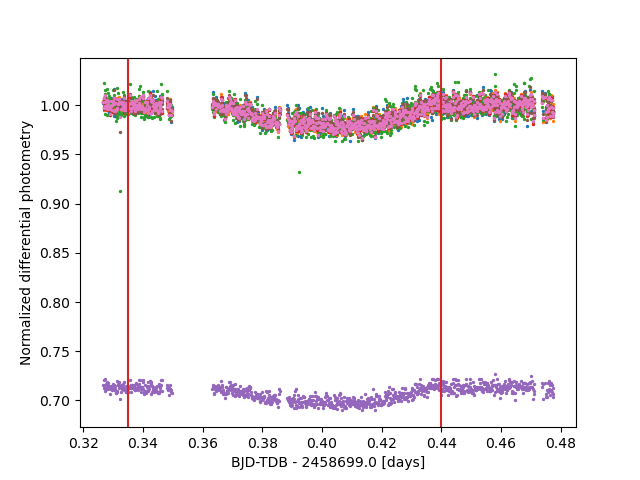

Standard deviation aperture 06 reference #1:           0.0068181
Standard deviation aperture 06 reference #2:           0.0062529
Standard deviation aperture 06 reference #3:           0.0102718
Standard deviation aperture 06 reference #1 and #2:    0.0057563
Standard deviation aperture 06 reference #1 and #3:    0.0042888
Standard deviation aperture 06 reference #2 and #3:    0.0060687
Standard deviation aperture 06 all references :        0.0055424


In [8]:
bjd_tdb = target_ap06.bjd_tdb
bjd_median = np.median(target_ap06.bjd_tdb)

# https://numpy.org/doc/stable/reference/routines.polynomials.package.html#module-numpy.polynomial
from numpy.polynomial import Polynomial

out_transit_selection = ((target_ap06.bjd_tdb < 2458699.3350000)  | ( target_ap06.bjd_tdb> 2458699.4400000)) & (target_ap06.bjd_tdb< 2458699.4800000)

poly_ap06_ref01_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref01[out_transit_selection], deg=1)
poly_ap06_ref02_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref02[out_transit_selection], deg=1)
poly_ap06_ref03_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref03[out_transit_selection], deg=1)
poly_ap06_ref01_ref02_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref01_ref02[out_transit_selection], deg=1)
poly_ap06_ref01_ref03_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref01_ref03[out_transit_selection], deg=1)
poly_ap06_ref02_ref03_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_ref01_ref03[out_transit_selection], deg=1)
poly_ap06_allref_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection]-bjd_median, differential_ap06_allref[out_transit_selection], deg=1)

differential_ap06_ref01_normalized = differential_ap06_ref01 / poly_ap06_ref01_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_ref02_normalized = differential_ap06_ref02 / poly_ap06_ref02_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_ref03_normalized = differential_ap06_ref03 / poly_ap06_ref03_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_ref01_ref02_normalized = differential_ap06_ref01_ref02 / poly_ap06_ref01_ref02_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_ref01_ref03_normalized = differential_ap06_ref02_ref03 / poly_ap06_ref01_ref03_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_ref02_ref03_normalized = differential_ap06_ref01_ref03 / poly_ap06_ref02_ref03_deg01_pfit(bjd_tdb-bjd_median)
differential_ap06_allref_normalized = differential_ap06_allref / poly_ap06_allref_deg01_pfit(bjd_tdb-bjd_median)

# Calcolo degli errori normalizzati per le diverse combinazioni di reference stars
differential_ap06_ref01_normalized_error = differential_ap06_ref01_error / poly_ap06_ref01_deg01_pfit(bjd_tdb - bjd_median)
differential_ap06_ref02_normalized_error = differential_ap06_ref02_error / poly_ap06_ref02_deg01_pfit(bjd_tdb - bjd_median)
differential_ap06_ref03_normalized_error = differential_ap06_ref03_error / poly_ap06_ref03_deg01_pfit(bjd_tdb - bjd_median)

differential_ap06_ref01_ref02_normalized_error = differential_ap06_ref01_ref02_error / poly_ap06_ref01_ref02_deg01_pfit(bjd_tdb - bjd_median)
differential_ap06_ref01_ref03_normalized_error = differential_ap06_ref01_ref03_error / poly_ap06_ref01_ref03_deg01_pfit(bjd_tdb - bjd_median)
differential_ap06_ref02_ref03_normalized_error = differential_ap06_ref02_ref03_error / poly_ap06_ref02_ref03_deg01_pfit(bjd_tdb - bjd_median)

differential_ap06_allref_normalized_error = differential_ap06_allref_error / poly_ap06_allref_deg01_pfit(bjd_tdb - bjd_median)


plt.figure()
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref01_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref02_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref03_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref01_ref02_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref01_ref03_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_ref02_ref03_normalized, s=2)
plt.scatter(bjd_tdb-time_offset, differential_ap06_allref_normalized, s=2)

plt.axvline(2458699.3350000-time_offset, c='C3')
plt.axvline(2458699.4400000-time_offset, c='C3')
#plt.ylim(0.975, 1.025)

plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Normalized differential photometry')
plt.show()

print('Standard deviation aperture 06 reference #1:           {0:.7f}'.format(np.std(differential_ap06_ref01_normalized[out_transit_selection])))
print('Standard deviation aperture 06 reference #2:           {0:.7f}'.format(np.std(differential_ap06_ref02_normalized[out_transit_selection])))
print('Standard deviation aperture 06 reference #3:           {0:.7f}'.format(np.std(differential_ap06_ref03_normalized[out_transit_selection])))
print('Standard deviation aperture 06 reference #1 and #2:    {0:.7f}'.format(np.std(differential_ap06_ref01_ref02_normalized[out_transit_selection])))
print('Standard deviation aperture 06 reference #1 and #3:    {0:.7f}'.format(np.std(differential_ap06_ref01_ref03_normalized[out_transit_selection])))
print('Standard deviation aperture 06 reference #2 and #3:    {0:.7f}'.format(np.std(differential_ap06_ref02_ref03_normalized[out_transit_selection])))
print('Standard deviation aperture 06 all references :        {0:.7f}'.format(np.std(differential_ap06_allref_normalized[out_transit_selection])))


From the results above we conclude that the combination of the first and third reference star is providing the best differential photometry.

In [9]:
pickle.dump(bjd_tdb, open('taste_bjdtdb.p','wb'))
pickle.dump(differential_ap06_ref01_normalized, open('differential_ap06_ref01_normalized.p','wb'))
pickle.dump(differential_ap06_ref01_normalized_error, open('differential_ap06_ref01_normalized_error.p','wb'))
pickle.dump(differential_ap06_ref02_normalized, open('differential_ap06_ref02_normalized.p','wb'))
pickle.dump(differential_ap06_ref02_normalized_error, open('differential_ap06_ref02_normalized_error.p','wb'))
pickle.dump(differential_ap06_ref03_normalized, open('differential_ap06_ref03_normalized.p','wb'))
pickle.dump(differential_ap06_ref03_normalized_error, open('differential_ap06_ref03_normalized_error.p','wb'))

pickle.dump(differential_ap06_ref01_ref02_normalized, open('differential_ap06_ref01_ref02_normalized.p','wb'))
pickle.dump(differential_ap06_ref01_ref02_normalized_error, open('differential_ap06_ref01_ref02_normalized_error.p','wb'))
pickle.dump(differential_ap06_ref01_ref03_normalized, open('differential_ap06_ref01_ref03_normalized.p','wb'))
pickle.dump(differential_ap06_ref01_ref03_normalized_error, open('differential_ap06_ref01_ref03_normalized_error.p','wb'))
pickle.dump(differential_ap06_ref02_ref03_normalized, open('differential_ap06_ref02_ref03_normalized.p','wb'))
pickle.dump(differential_ap06_ref02_ref03_normalized_error, open('differential_ap06_ref02_ref03_normalized_error.p','wb'))

pickle.dump(differential_ap06_allref_normalized, open('differential_ap06_allref_normalized.p','wb'))
pickle.dump(differential_ap06_allref_normalized_error, open('differential_ap06_allref_normalized_error.p','wb'))

pickle.dump(differential_ap06_ref01, open('differential_ap06_ref01.p','wb'))
pickle.dump(differential_ap06_ref01_error, open('differential_ap06_ref01_error.p','wb'))
pickle.dump(differential_ap06_ref02, open('differential_ap06_ref02.p','wb'))
pickle.dump(differential_ap06_ref02_error, open('differential_ap06_ref02_error.p','wb'))
pickle.dump(differential_ap06_ref03, open('differential_ap06_ref03.p','wb'))
pickle.dump(differential_ap06_ref03_error, open('differential_ap06_ref03_error.p','wb'))

pickle.dump(differential_ap06_ref01_ref02, open('differential_ap06_ref01_ref02.p','wb'))
pickle.dump(differential_ap06_ref01_ref02_error, open('differential_ap06_ref01_ref02_error.p','wb'))
pickle.dump(differential_ap06_ref01_ref03, open('differential_ap06_ref01_ref03.p','wb'))
pickle.dump(differential_ap06_ref01_ref03_error, open('differential_ap06_ref01_ref03_error.p','wb'))
pickle.dump(differential_ap06_ref02_ref03, open('differential_ap06_ref02_ref03.p','wb'))
pickle.dump(differential_ap06_ref02_ref03_error, open('differential_ap06_ref02_ref03_error.p','wb'))

pickle.dump(differential_ap06_allref, open('differential_ap06_allref.p','wb'))
pickle.dump(differential_ap06_allref_error, open('differential_ap06_allref_error.p','wb'))

 